In [1]:
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
from sklearn.model_selection import cross_val_score

# The data

The dataset I am using is the Economic Freedom Index Dataset. It contains information on most countries in the world on measure of economic freedom such as trade and labor freedoms, and tax and tariff rates. It also contains measures of fiscal health and GDP growth.

Data is from: https://www.kaggle.com/lewisduncan93/the-economic-freedom-index

In [2]:
econ_data = pd.read_csv('economic_freedom_index2019_data.csv', encoding="latin1")

In [3]:
econ_data.head()

,CountryID,Country Name,WEBNAME,Region,World Rank,Region Rank,2019 Score,Property Rights,Judical Effectiveness,Government Integrity,...,Country,Population (Millions),"GDP (Billions, PPP)",GDP Growth Rate (%),5 Year GDP Growth Rate (%),GDP per Capita (PPP),Unemployment (%),Inflation (%),FDI Inflow (Millions),Public Debt (% of GDP)
0,1,Afghanistan,Afghanistan,Asia-Pacific,152.0,39.0,51.5,19.6,29.6,25.2,...,Afghanistan,35.5,$69.6,2.5,2.9,"$1,958",8.8,5.0,53.9,7.3
1,2,Albania,Albania,Europe,52.0,27.0,66.5,54.8,30.6,40.4,...,Albania,2.9,$36.0,3.9,2.5,"$12,507",13.9,2.0,"1,119.1",71.2
2,3,Algeria,Algeria,Middle East and North Africa,171.0,14.0,46.2,31.6,36.2,28.9,...,Algeria,41.5,$632.9,2.0,3.1,"$15,237",10.0,5.6,"1,203.0",25.8
3,4,Angola,Angola,Sub-Saharan Africa,156.0,33.0,50.6,35.9,26.6,20.5,...,Angola,28.2,$190.3,0.7,2.9,"$6,753",8.2,31.7,"-2,254.5",65.3
4,5,Argentina,Argentina,Americas,148.0,26.0,52.2,47.8,44.5,33.5,...,Argentina,44.1,$920.2,2.9,0.7,"$20,876",8.7,25.7,"11,857.0",52.6


In [4]:
econ_data.columns

Index(['CountryID', 'Country Name', 'WEBNAME', 'Region', 'World Rank',
       'Region Rank', '2019 Score', 'Property Rights', 'Judical Effectiveness',
       'Government Integrity', 'Tax Burden', 'Gov't Spending', 'Fiscal Health',
       'Business Freedom', 'Labor Freedom', 'Monetary Freedom',
       'Trade Freedom', 'Investment Freedom ', 'Financial Freedom',
       'Tariff Rate (%)', 'Income Tax Rate (%)', 'Corporate Tax Rate (%)',
       'Tax Burden % of GDP', 'Gov't Expenditure % of GDP ', 'Country',
       'Population (Millions)', 'GDP (Billions, PPP)', 'GDP Growth Rate (%)',
       '5 Year GDP Growth Rate (%)', 'GDP per Capita (PPP)',
       'Unemployment (%)', 'Inflation (%)', 'FDI Inflow (Millions)',
       'Public Debt (% of GDP)'],
      dtype='object')

I will investigate whether we can predict the 5 year GDP Growth Rate from the Tariff Rate, Income Tax Rate and Corporate Tax Rate.

In [5]:
econ_data.columns = econ_data.columns.str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [6]:
econ_data.columns

Index(['countryid', 'country_name', 'webname', 'region', 'world_rank',
       'region_rank', '2019_score', 'property_rights', 'judical_effectiveness',
       'government_integrity', 'tax_burden', 'gov't_spending', 'fiscal_health',
       'business_freedom', 'labor_freedom', 'monetary_freedom',
       'trade_freedom', 'investment_freedom_', 'financial_freedom',
       'tariff_rate_%', 'income_tax_rate_%', 'corporate_tax_rate_%',
       'tax_burden_%_of_gdp', 'gov't_expenditure_%_of_gdp_', 'country',
       'population_millions', 'gdp_billions,_ppp', 'gdp_growth_rate_%',
       '5_year_gdp_growth_rate_%', 'gdp_per_capita_ppp', 'unemployment_%',
       'inflation_%', 'fdi_inflow_millions', 'public_debt_%_of_gdp'],
      dtype='object')

# Model 1
## Predicting the 5 year GDP growth rate from tariff and tax rates
### Data

In [7]:
gdp_indicators = pd.DataFrame({
    'tariff_rate': econ_data['tariff_rate_%'],
    'income_tax_rate': econ_data['income_tax_rate_%'],
    'corporate_tax_rate': econ_data['corporate_tax_rate_%'],
    '5_year_GDP': econ_data['5_year_gdp_growth_rate_%']
})
gdp_indicators.head()

,tariff_rate,income_tax_rate,corporate_tax_rate,5_year_GDP
0,7.0,20.0,20.0,2.9
1,1.1,23.0,15.0,2.5
2,8.8,35.0,23.0,3.1
3,9.4,17.0,30.0,2.9
4,7.5,35.0,30.0,0.7


In [8]:
gdp_indicators[gdp_indicators.isnull().any(axis=1)]

,tariff_rate,income_tax_rate,corporate_tax_rate,5_year_GDP
78,NaN,15.0,15.0,4.7
88,50.0,NaN,NaN,NaN
98,NaN,10.0,20.0,-7.9
99,NaN,7.0,12.5,NaN
153,NaN,NaN,NaN,2.2
161,16.5,22.0,28.0,NaN
183,4.3,NaN,NaN,-16.1


In [9]:
gdp_indicators = gdp_indicators.dropna().reset_index().drop('index', axis=1)

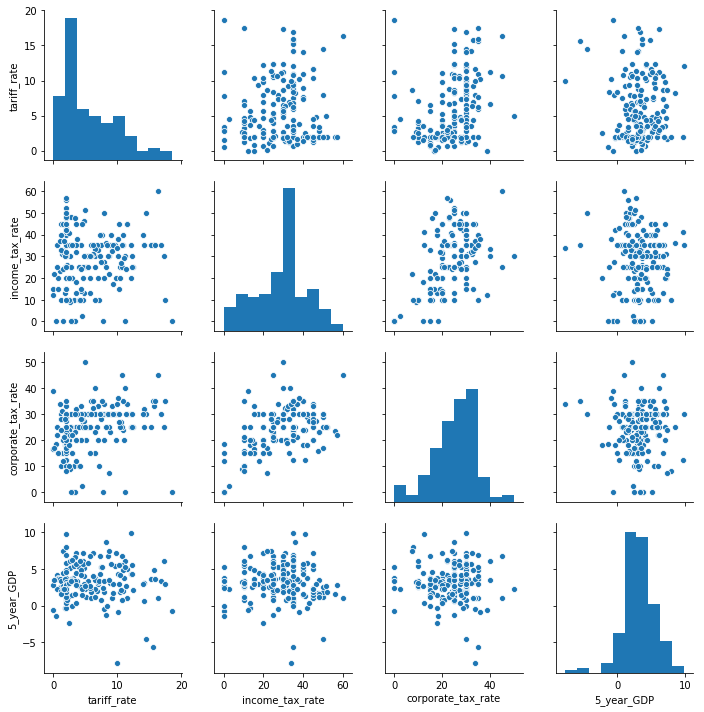

In [10]:
sns.pairplot(gdp_indicators, diag_kind='hist')
plt.show()

In [11]:
X_gdp = gdp_indicators[['tariff_rate', 'income_tax_rate', 'corporate_tax_rate']]
Y_gdp = gdp_indicators['5_year_GDP']

### KNN Regression

In [12]:
def knn_func(n_min, n_max, weights):
    for n in np.arange(n_min, n_max+1):
        knn_model = KNeighborsRegressor(n_neighbors=n, weights=weights)
        knn_rsq = cross_val_score(knn_model, X_gdp, Y_gdp, cv=5)
        print('R-squared %0.0f neighbors: Mean %0.2f (+/- %0.2f)' % (n, knn_rsq.mean(), knn_rsq.std()*2))
        

In [13]:
knn_func(1, 20, 'uniform')

R-squared 1 neighbors: Mean -0.82 (+/- 1.46)
R-squared 2 neighbors: Mean -0.45 (+/- 0.52)
R-squared 3 neighbors: Mean -0.34 (+/- 0.31)
R-squared 4 neighbors: Mean -0.30 (+/- 0.33)
R-squared 5 neighbors: Mean -0.24 (+/- 0.36)
R-squared 6 neighbors: Mean -0.22 (+/- 0.22)
R-squared 7 neighbors: Mean -0.19 (+/- 0.17)
R-squared 8 neighbors: Mean -0.17 (+/- 0.20)
R-squared 9 neighbors: Mean -0.15 (+/- 0.18)
R-squared 10 neighbors: Mean -0.14 (+/- 0.19)
R-squared 11 neighbors: Mean -0.11 (+/- 0.24)
R-squared 12 neighbors: Mean -0.09 (+/- 0.26)
R-squared 13 neighbors: Mean -0.07 (+/- 0.24)
R-squared 14 neighbors: Mean -0.07 (+/- 0.23)
R-squared 15 neighbors: Mean -0.09 (+/- 0.20)
R-squared 16 neighbors: Mean -0.09 (+/- 0.22)
R-squared 17 neighbors: Mean -0.11 (+/- 0.17)
R-squared 18 neighbors: Mean -0.10 (+/- 0.17)
R-squared 19 neighbors: Mean -0.08 (+/- 0.17)
R-squared 20 neighbors: Mean -0.09 (+/- 0.20)


In [14]:
knn_func(1, 20, 'distance')

R-squared 1 neighbors: Mean -0.82 (+/- 1.46)
R-squared 2 neighbors: Mean -0.50 (+/- 0.75)
R-squared 3 neighbors: Mean -0.43 (+/- 0.52)
R-squared 4 neighbors: Mean -0.39 (+/- 0.46)
R-squared 5 neighbors: Mean -0.30 (+/- 0.39)
R-squared 6 neighbors: Mean -0.28 (+/- 0.29)
R-squared 7 neighbors: Mean -0.26 (+/- 0.25)
R-squared 8 neighbors: Mean -0.24 (+/- 0.28)
R-squared 9 neighbors: Mean -0.23 (+/- 0.26)
R-squared 10 neighbors: Mean -0.21 (+/- 0.24)
R-squared 11 neighbors: Mean -0.19 (+/- 0.28)
R-squared 12 neighbors: Mean -0.17 (+/- 0.25)
R-squared 13 neighbors: Mean -0.15 (+/- 0.24)
R-squared 14 neighbors: Mean -0.14 (+/- 0.24)
R-squared 15 neighbors: Mean -0.15 (+/- 0.25)
R-squared 16 neighbors: Mean -0.15 (+/- 0.26)
R-squared 17 neighbors: Mean -0.15 (+/- 0.25)
R-squared 18 neighbors: Mean -0.14 (+/- 0.24)
R-squared 19 neighbors: Mean -0.13 (+/- 0.23)
R-squared 20 neighbors: Mean -0.13 (+/- 0.25)


None of these models are any good.

### OLS Regression

In [15]:
regr_gdp = linear_model.LinearRegression()

regr_gdp_scores = cross_val_score(regr_gdp, X_gdp, Y_gdp, cv=5)

print('R-squared OLS: %0.2f (+/- %0.2f)'% (regr_gdp_scores.mean(), regr_gdp_scores.std()*2))

R-squared OLS: -0.11 (+/- 0.12)


This is also a bad model. Check the residuals to see if it was a good fit.

In [16]:
regr_gdp.fit(X_gdp, Y_gdp)
Y_pred_gdp = regr_gdp.predict(X_gdp)

residuals_gdp = Y_pred_gdp - Y_gdp

results_gdp = pd.DataFrame()
results_gdp['actual'] = Y_gdp
results_gdp['predicted'] = Y_pred_gdp
results_gdp['residuals'] = residuals_gdp

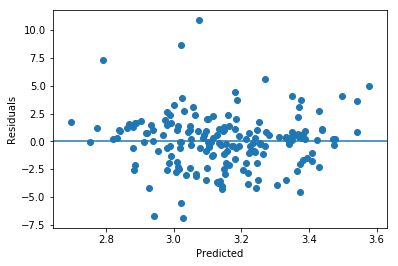

In [17]:
plt.scatter('predicted', 'residuals', data=results_gdp)
plt.axhline(y=0)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.show()

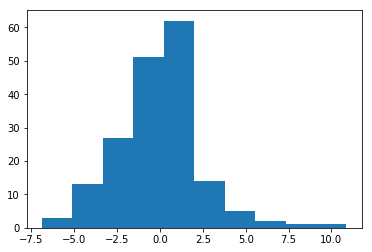

In [18]:
plt.hist(residuals_gdp)
plt.show()

### Model 1 Results

These models are similarly poor at predicting 5 year GDP from tariff rates, income tax rates and corporate tax rates, suggesting that 5 year GDP can not be predicted well from these values.

Both models have a similar R-squared value when considering KNN models with neighbors over 10.

# Model 2

## Use the dataset's measures of economic freedom to predict economic growth.

### Data

In [19]:
gdp_indicators_2 = econ_data.loc[:, ['property_rights', 'judical_effectiveness', 'government_integrity',
                                   'tax_burden', "gov't_spending", 'fiscal_health', 'business_freedom', 
                                  'labor_freedom', 'monetary_freedom', 'trade_freedom', 'investment_freedom_',
                                  'financial_freedom', '5_year_gdp_growth_rate_%']].copy()

In [20]:
gdp_indicators_2[gdp_indicators_2.isnull().any(axis=1) ]

,property_rights,judical_effectiveness,government_integrity,tax_burden,gov't_spending,fiscal_health,business_freedom,labor_freedom,monetary_freedom,trade_freedom,investment_freedom_,financial_freedom,5_year_gdp_growth_rate_%
78,37.0,12.3,20.3,NaN,52.8,13.3,54.4,53.1,81.4,NaN,NaN,NaN,4.7
88,31.6,5.0,24.4,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,NaN
98,7.6,24.4,15.8,NaN,0.0,20.0,40.2,51.3,52.8,NaN,5.0,NaN,-7.9
99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.0,80.0,NaN
153,33.7,26.6,7.9,NaN,NaN,NaN,31.7,NaN,NaN,NaN,NaN,NaN,2.2
161,37.0,24.4,20.3,NaN,NaN,NaN,49.6,58.2,48.3,47.0,0.0,NaN,NaN
183,19.6,22.2,20.3,NaN,83.7,0.0,45.1,49.8,61.5,71.4,50.0,NaN,-16.1


In [21]:
gdp_indicators_2 = gdp_indicators_2.dropna().reset_index().drop('index', axis=1)

In [22]:
X_gdp_2 = gdp_indicators_2.drop('5_year_gdp_growth_rate_%', axis=1)
Y_gdp_2 = gdp_indicators_2['5_year_gdp_growth_rate_%']

### KNN Regression

In [23]:
def knn_func(n_min, n_max, weights):
    for n in np.arange(n_min, n_max+1):
        knn_model = KNeighborsRegressor(n_neighbors=n, weights=weights)
        knn_rsq = cross_val_score(knn_model, X_gdp_2, Y_gdp_2, cv=5)
        print('R-squared %0.0f neighbors: Mean %0.2f (+/- %0.2f)' % (n, knn_rsq.mean(), knn_rsq.std()*2))
        

In [24]:
knn_func(1, 20, 'uniform')

R-squared 1 neighbors: Mean -0.65 (+/- 0.65)
R-squared 2 neighbors: Mean -0.33 (+/- 0.40)
R-squared 3 neighbors: Mean -0.19 (+/- 0.35)
R-squared 4 neighbors: Mean -0.09 (+/- 0.27)
R-squared 5 neighbors: Mean -0.07 (+/- 0.27)
R-squared 6 neighbors: Mean -0.04 (+/- 0.23)
R-squared 7 neighbors: Mean -0.05 (+/- 0.25)
R-squared 8 neighbors: Mean 0.00 (+/- 0.23)
R-squared 9 neighbors: Mean -0.00 (+/- 0.25)
R-squared 10 neighbors: Mean 0.01 (+/- 0.23)
R-squared 11 neighbors: Mean 0.00 (+/- 0.24)
R-squared 12 neighbors: Mean 0.01 (+/- 0.26)
R-squared 13 neighbors: Mean 0.01 (+/- 0.24)
R-squared 14 neighbors: Mean 0.02 (+/- 0.27)
R-squared 15 neighbors: Mean 0.02 (+/- 0.25)
R-squared 16 neighbors: Mean 0.03 (+/- 0.25)
R-squared 17 neighbors: Mean 0.02 (+/- 0.26)
R-squared 18 neighbors: Mean 0.02 (+/- 0.24)
R-squared 19 neighbors: Mean 0.03 (+/- 0.22)
R-squared 20 neighbors: Mean 0.02 (+/- 0.22)


In [25]:
knn_func(1, 20, 'distance')

R-squared 1 neighbors: Mean -0.65 (+/- 0.65)
R-squared 2 neighbors: Mean -0.33 (+/- 0.41)
R-squared 3 neighbors: Mean -0.19 (+/- 0.36)
R-squared 4 neighbors: Mean -0.10 (+/- 0.27)
R-squared 5 neighbors: Mean -0.07 (+/- 0.27)
R-squared 6 neighbors: Mean -0.04 (+/- 0.24)
R-squared 7 neighbors: Mean -0.04 (+/- 0.25)
R-squared 8 neighbors: Mean 0.00 (+/- 0.23)
R-squared 9 neighbors: Mean -0.00 (+/- 0.25)
R-squared 10 neighbors: Mean 0.01 (+/- 0.23)
R-squared 11 neighbors: Mean 0.01 (+/- 0.23)
R-squared 12 neighbors: Mean 0.02 (+/- 0.25)
R-squared 13 neighbors: Mean 0.02 (+/- 0.24)
R-squared 14 neighbors: Mean 0.02 (+/- 0.26)
R-squared 15 neighbors: Mean 0.03 (+/- 0.25)
R-squared 16 neighbors: Mean 0.03 (+/- 0.25)
R-squared 17 neighbors: Mean 0.02 (+/- 0.25)
R-squared 18 neighbors: Mean 0.02 (+/- 0.25)
R-squared 19 neighbors: Mean 0.03 (+/- 0.23)
R-squared 20 neighbors: Mean 0.03 (+/- 0.22)


### OLS Regression

In [26]:
regr_gdp_2 = linear_model.LinearRegression()

regr_gdp_2.fit(X_gdp_2, Y_gdp_2)

Y_gdp_pred_2 = regr_gdp_2.predict(X_gdp_2)

results_gdp_2 = pd.DataFrame({
    'actual': Y_gdp_2,
    'predicted': Y_gdp_pred_2,
    'residuals': (Y_gdp_2 - Y_gdp_pred_2)
})

In [27]:
regr_gdp_2_scores = cross_val_score(regr_gdp_2, X_gdp_2, Y_gdp_2, cv=5)
print('R-squared OLS: %0.2f (+/-) %0.2f' % (regr_gdp_2_scores.mean(), regr_gdp_2_scores.std()*2))

R-squared OLS: -0.15 (+/-) 0.38


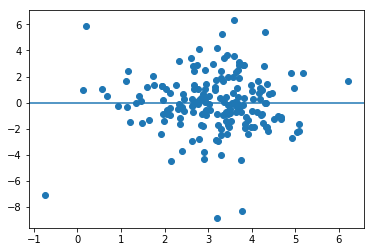

In [28]:
plt.scatter('predicted', 'residuals', data=results_gdp_2)
plt.axhline(y=0)
plt.show()

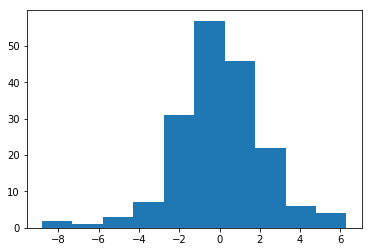

In [29]:
plt.hist(results_gdp_2.residuals)
plt.show()

### Model 2 Results
Both KNN and OLS are terrible at predicting 5 year GDP from economic freedom indicators.

# Model 3
## See if Fiscal Health can be predicted from Economic Freedoms
### Data

In [30]:
fh_indicators = gdp_indicators_2.drop(['property_rights', 'judical_effectiveness', 'government_integrity', 'tax_burden', "gov't_spending", '5_year_gdp_growth_rate_%'], axis=1)

In [31]:
fh_indicators.head()

,fiscal_health,business_freedom,labor_freedom,monetary_freedom,trade_freedom,investment_freedom_,financial_freedom
0,99.3,49.2,60.4,76.7,66.0,10.0,10.0
1,80.6,69.3,52.7,81.5,87.8,70.0,70.0
2,18.7,61.6,49.9,74.9,67.4,30.0,30.0
3,58.2,55.7,58.8,55.4,61.2,30.0,40.0
4,33.0,56.4,46.9,60.2,70.0,55.0,60.0


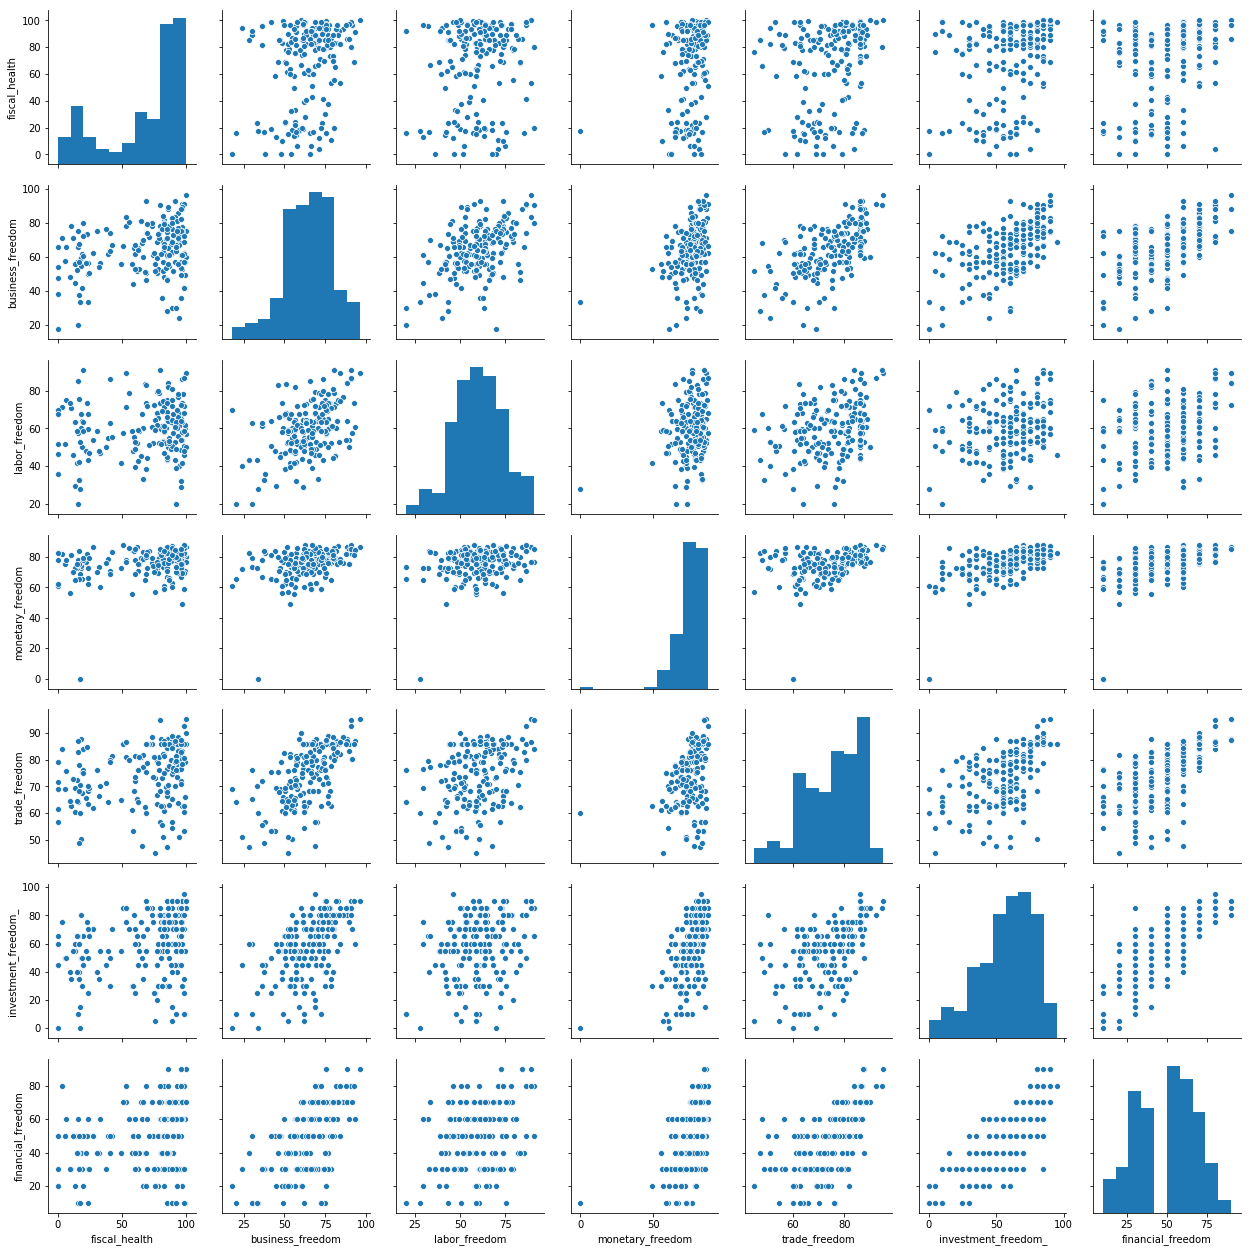

In [32]:
sns.pairplot(fh_indicators)
plt.show()

In [33]:
fh_indicators.loc[fh_indicators.monetary_freedom < 10, ]

,fiscal_health,business_freedom,labor_freedom,monetary_freedom,trade_freedom,investment_freedom_,financial_freedom
175,17.6,33.9,28.0,0.0,60.0,0.0,10.0


In [34]:
fh_indicators.loc[fh_indicators.isnull().any(axis=1)]

,fiscal_health,business_freedom,labor_freedom,monetary_freedom,trade_freedom,investment_freedom_,financial_freedom


In [35]:
econ_data.loc[econ_data['monetary_freedom'] < 10, ['country','monetary_freedom']]

,country,monetary_freedom
88,"Korea, North",0.0
181,Venezuela,0.0


In [36]:
## Seems reasonable

In [37]:
X_fh = fh_indicators.drop(['fiscal_health'], axis=1)
Y_fh = fh_indicators['fiscal_health']

### KNN Regression

In [38]:
def knn_func_fh(n_min, n_max, weights):
    for n in np.arange(n_min, n_max+1):
        knn_test_fh = KNeighborsRegressor(n_neighbors = n, weights=weights)
        knn_score_fh = cross_val_score(knn_test_fh, X_fh, Y_fh, cv=5)
        print('R-squared %0.0f neighbors: %0.2f (+/- %0.2f)' % (n, knn_score_fh.mean(), knn_score_fh.std()*2))

In [39]:
knn_func_fh(1, 20, 'uniform')

R-squared 1 neighbors: -0.95 (+/- 0.45)
R-squared 2 neighbors: -0.36 (+/- 0.43)
R-squared 3 neighbors: -0.27 (+/- 0.33)
R-squared 4 neighbors: -0.15 (+/- 0.13)
R-squared 5 neighbors: -0.11 (+/- 0.10)
R-squared 6 neighbors: -0.08 (+/- 0.09)
R-squared 7 neighbors: -0.03 (+/- 0.13)
R-squared 8 neighbors: 0.00 (+/- 0.16)
R-squared 9 neighbors: 0.03 (+/- 0.14)
R-squared 10 neighbors: 0.04 (+/- 0.10)
R-squared 11 neighbors: 0.05 (+/- 0.12)
R-squared 12 neighbors: 0.07 (+/- 0.14)
R-squared 13 neighbors: 0.08 (+/- 0.13)
R-squared 14 neighbors: 0.07 (+/- 0.13)
R-squared 15 neighbors: 0.08 (+/- 0.16)
R-squared 16 neighbors: 0.08 (+/- 0.15)
R-squared 17 neighbors: 0.07 (+/- 0.16)
R-squared 18 neighbors: 0.06 (+/- 0.19)
R-squared 19 neighbors: 0.06 (+/- 0.18)
R-squared 20 neighbors: 0.06 (+/- 0.19)


In [40]:
knn_func_fh(1, 20, 'distance')

R-squared 1 neighbors: -0.95 (+/- 0.45)
R-squared 2 neighbors: -0.38 (+/- 0.41)
R-squared 3 neighbors: -0.29 (+/- 0.32)
R-squared 4 neighbors: -0.17 (+/- 0.16)
R-squared 5 neighbors: -0.12 (+/- 0.13)
R-squared 6 neighbors: -0.10 (+/- 0.12)
R-squared 7 neighbors: -0.04 (+/- 0.15)
R-squared 8 neighbors: -0.02 (+/- 0.17)
R-squared 9 neighbors: 0.02 (+/- 0.14)
R-squared 10 neighbors: 0.03 (+/- 0.12)
R-squared 11 neighbors: 0.04 (+/- 0.12)
R-squared 12 neighbors: 0.05 (+/- 0.12)
R-squared 13 neighbors: 0.06 (+/- 0.11)
R-squared 14 neighbors: 0.06 (+/- 0.11)
R-squared 15 neighbors: 0.07 (+/- 0.12)
R-squared 16 neighbors: 0.07 (+/- 0.12)
R-squared 17 neighbors: 0.06 (+/- 0.13)
R-squared 18 neighbors: 0.06 (+/- 0.15)
R-squared 19 neighbors: 0.05 (+/- 0.15)
R-squared 20 neighbors: 0.06 (+/- 0.16)


### OLS Regression

In [41]:
regr_fh = linear_model.LinearRegression()
regr_fh.fit(X_fh, Y_fh)
Y_pred_fh = regr_fh.predict(X_fh)

In [42]:
regr_fh_cv = cross_val_score(regr_fh, X_fh, Y_fh, cv=5)

regr_fh_cv.mean()

0.020327669845414807

### Model 3 Results
Again, both KNN Regression and OLS Regression are terrible at predicting fiscal health from economic freedom indicators.

# Model 4
## Predict labor freedom from other freedoms
### Data

In [43]:
lf_indicators = fh_indicators.drop(['fiscal_health'], axis=1)

In [44]:
X_lf = lf_indicators.drop('labor_freedom', axis=1)
Y_lf = lf_indicators['labor_freedom']

### KNN Regression

In [45]:
def knn_func_lf(n_min, n_max, weights):
    for n in np.arange(n_min, n_max+1):
        knn_test_lf = KNeighborsRegressor(n_neighbors=n, weights=weights)
        knn_test_lf_score = cross_val_score(knn_test_lf, X_lf, Y_lf, cv=5)
        print('R-squared %0.0f neighbors: %0.2f (+/- %0.2f)' % (n, knn_test_lf_score.mean(), knn_test_lf_score.std()*2))

In [46]:
knn_func_lf(1, 20, 'uniform')

R-squared 1 neighbors: -0.53 (+/- 0.99)
R-squared 2 neighbors: -0.26 (+/- 0.34)
R-squared 3 neighbors: -0.12 (+/- 0.29)
R-squared 4 neighbors: 0.05 (+/- 0.22)
R-squared 5 neighbors: 0.09 (+/- 0.20)
R-squared 6 neighbors: 0.10 (+/- 0.15)
R-squared 7 neighbors: 0.09 (+/- 0.18)
R-squared 8 neighbors: 0.09 (+/- 0.16)
R-squared 9 neighbors: 0.11 (+/- 0.20)
R-squared 10 neighbors: 0.13 (+/- 0.16)
R-squared 11 neighbors: 0.13 (+/- 0.16)
R-squared 12 neighbors: 0.13 (+/- 0.17)
R-squared 13 neighbors: 0.11 (+/- 0.17)
R-squared 14 neighbors: 0.12 (+/- 0.15)
R-squared 15 neighbors: 0.11 (+/- 0.16)
R-squared 16 neighbors: 0.11 (+/- 0.18)
R-squared 17 neighbors: 0.09 (+/- 0.18)
R-squared 18 neighbors: 0.11 (+/- 0.17)
R-squared 19 neighbors: 0.10 (+/- 0.19)
R-squared 20 neighbors: 0.09 (+/- 0.17)


In [47]:
knn_func_lf(1, 20, 'distance')

R-squared 1 neighbors: -0.53 (+/- 0.99)
R-squared 2 neighbors: -0.26 (+/- 0.40)
R-squared 3 neighbors: -0.11 (+/- 0.33)
R-squared 4 neighbors: 0.05 (+/- 0.26)
R-squared 5 neighbors: 0.08 (+/- 0.23)
R-squared 6 neighbors: 0.10 (+/- 0.17)
R-squared 7 neighbors: 0.10 (+/- 0.17)
R-squared 8 neighbors: 0.10 (+/- 0.16)
R-squared 9 neighbors: 0.11 (+/- 0.18)
R-squared 10 neighbors: 0.13 (+/- 0.15)
R-squared 11 neighbors: 0.14 (+/- 0.15)
R-squared 12 neighbors: 0.13 (+/- 0.16)
R-squared 13 neighbors: 0.12 (+/- 0.15)
R-squared 14 neighbors: 0.12 (+/- 0.14)
R-squared 15 neighbors: 0.12 (+/- 0.14)
R-squared 16 neighbors: 0.12 (+/- 0.15)
R-squared 17 neighbors: 0.11 (+/- 0.16)
R-squared 18 neighbors: 0.12 (+/- 0.14)
R-squared 19 neighbors: 0.11 (+/- 0.15)
R-squared 20 neighbors: 0.11 (+/- 0.15)


### OLS Regression

In [48]:
regr_lf = linear_model.LinearRegression()

regr_lf_score = cross_val_score(regr_lf, X_lf, Y_lf, cv=5)

print("R-squared OLS: %0.2f (+/- %0.2f)" % (regr_lf_score.mean(), regr_lf_score.std()*2))

R-squared OLS: 0.16 (+/- 0.29)


### Model 4 Results
Both KNN and OLS Regression show a small, positive, non-statistically significant trend of increasing labor freedom with increases in the other freedoms.

# Model 5
## Predict labor freedom just from trade, business and financial freedoms
### Data

In [49]:
lf_2_indicators = lf_indicators.drop(['monetary_freedom', 'investment_freedom_'], axis=1)

In [50]:
X_lf_2 = lf_2_indicators.drop('labor_freedom', axis=1)
Y_lf_2 = lf_2_indicators['labor_freedom']

### KNN Regression

In [51]:
def knn_func_lf_2(n_min, n_max, weights):
    for n in np.arange(n_min, n_max):
        knn_lf_2 = KNeighborsRegressor(n_neighbors=n, weights=weights)
        knn_lf_2_score = cross_val_score(knn_lf_2, X_lf_2, Y_lf_2, cv=5)
        print('R-squared %0.0f neighbors: %0.2f (+/- %0.2f)' % (n, knn_lf_2_score.mean(), knn_lf_2_score.std()*2))

In [52]:
knn_func_lf_2(1, 20, 'uniform')

R-squared 1 neighbors: -0.82 (+/- 0.85)
R-squared 2 neighbors: -0.30 (+/- 0.55)
R-squared 3 neighbors: -0.09 (+/- 0.41)
R-squared 4 neighbors: 0.02 (+/- 0.42)
R-squared 5 neighbors: 0.07 (+/- 0.27)
R-squared 6 neighbors: 0.02 (+/- 0.26)
R-squared 7 neighbors: 0.04 (+/- 0.24)
R-squared 8 neighbors: 0.09 (+/- 0.19)
R-squared 9 neighbors: 0.12 (+/- 0.21)
R-squared 10 neighbors: 0.12 (+/- 0.22)
R-squared 11 neighbors: 0.13 (+/- 0.19)
R-squared 12 neighbors: 0.14 (+/- 0.17)
R-squared 13 neighbors: 0.15 (+/- 0.13)
R-squared 14 neighbors: 0.15 (+/- 0.12)
R-squared 15 neighbors: 0.14 (+/- 0.14)
R-squared 16 neighbors: 0.14 (+/- 0.13)
R-squared 17 neighbors: 0.14 (+/- 0.12)
R-squared 18 neighbors: 0.13 (+/- 0.12)
R-squared 19 neighbors: 0.12 (+/- 0.13)


In [53]:
knn_func_lf_2(1, 20, 'distance')

R-squared 1 neighbors: -0.82 (+/- 0.85)
R-squared 2 neighbors: -0.37 (+/- 0.55)
R-squared 3 neighbors: -0.19 (+/- 0.43)
R-squared 4 neighbors: -0.09 (+/- 0.41)
R-squared 5 neighbors: -0.04 (+/- 0.29)
R-squared 6 neighbors: -0.06 (+/- 0.29)
R-squared 7 neighbors: -0.03 (+/- 0.26)
R-squared 8 neighbors: 0.00 (+/- 0.22)
R-squared 9 neighbors: 0.03 (+/- 0.22)
R-squared 10 neighbors: 0.04 (+/- 0.24)
R-squared 11 neighbors: 0.05 (+/- 0.21)
R-squared 12 neighbors: 0.06 (+/- 0.18)
R-squared 13 neighbors: 0.08 (+/- 0.15)
R-squared 14 neighbors: 0.08 (+/- 0.14)
R-squared 15 neighbors: 0.08 (+/- 0.15)
R-squared 16 neighbors: 0.08 (+/- 0.15)
R-squared 17 neighbors: 0.08 (+/- 0.14)
R-squared 18 neighbors: 0.08 (+/- 0.14)
R-squared 19 neighbors: 0.07 (+/- 0.15)


### OLS Regression

In [54]:
regr_lf_2 = linear_model.LinearRegression()

regr_lf_2.fit(X_lf_2, Y_lf_2)

regr_lf_2_score = cross_val_score(regr_lf_2, X_lf_2, Y_lf_2, cv=5)

print('R-squared OLS: %0.2f (+/- %0.2f)' % (regr_lf_2_score.mean(), regr_lf_2_score.std()*2))

R-squared OLS: 0.16 (+/- 0.28)


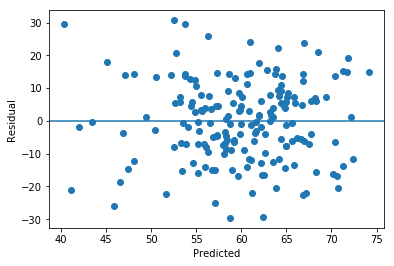

In [55]:
results_lf_2 = pd.DataFrame({
    'actual': Y_lf_2,
    'predicted': regr_lf_2.predict(X_lf_2)
})
results_lf_2['residuals'] = results_lf_2['actual'] - results_lf_2['predicted']

plt.scatter('predicted', 'residuals', data=results_lf_2)
plt.axhline(y=0)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.show()

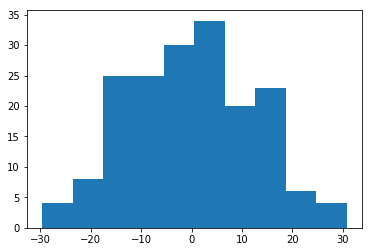

In [56]:
plt.hist(results_lf_2.residuals)
plt.show()

### Model 5 Results
KNN Regression with 13 neighbours uniform weighting shows a just-about-significant positive trend. However, it is so small it is negligible.

## Conclusions
Unfortunately none of these experiments let me definitely choose one model over the other as all the results were very poor. However, given the way the models work, I would be more likely to favor OLS Regression when I expected a linear trend. I would be more likely to favor a KNN Regression if I expected the trend to be less linear - for example it might increase at the start and end and decrease in the middle.

Here, both models performed poorly because there was no clear trend in the outcome variable compared to the income variables. I find this surprising, as I expected countries with greater economic freedom to benefit from higher GDP and fiscal health. I also expected all the freedoms to cluster together, so a high score in one area I expected to be indicative of another. However, it appears as though the trends are limited, and it is possible to be an economically successful country with little economic freedom (e.g. Saudi Arabia).